# Causal Impact example - Bitcoin & Elon Musk

* In this notebook, we explore how to use CausalImpact package to analyze causal impact of an event on a time series data. 
* motivating example (image source : https://www.vox.com/recode/2021/5/18/22441831/elon-musk-bitcoin-dogecoin-crypto-prices-tesla)
<div>
<img src="../slides/elon_musk_tweet.png" width="600">
</div>

## Bitcoin price data & first look

* data source : yahoo finance data 
* https://finance.yahoo.com/chart/BTC-USD

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from causalimpact import CausalImpact

## First peek into the data

In [3]:
df = pd.read_csv("../data/bitcoin_historical_price.csv")
df.head()

,Date,Open,High,Low,Close,AdjClose
0,2021-06-12,37230.70,37358.46,34764.79,35841.09,35841.09
1,2021-06-11,36697.03,37608.70,36044.45,37334.40,37334.40
2,2021-06-10,37389.52,38334.32,35847.59,36702.60,36702.60
3,2021-06-09,33416.98,37537.37,32475.87,37345.12,37345.12
4,2021-06-08,33589.52,34017.39,31114.44,33472.63,33472.63


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
df.sort_index(ascending=True, inplace=True)

In [6]:
df_2021 = df[df.index.year>=2021].copy()

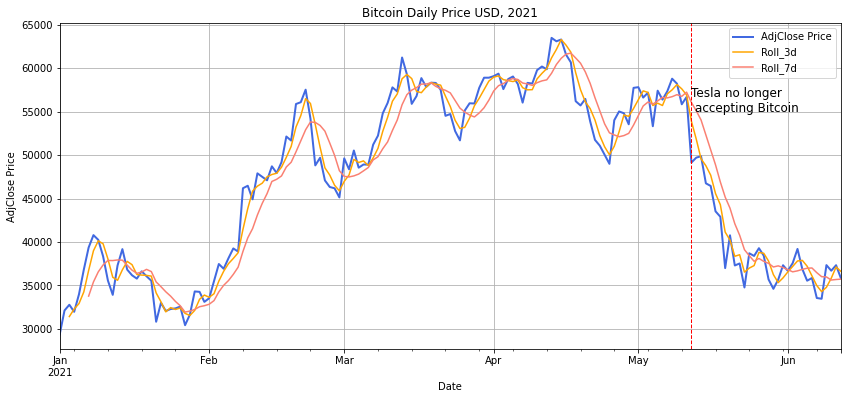

In [7]:
#@title Plot Close Price
fig, ax = plt.subplots(figsize=(14,6))
#ax.plot(df['AdjClose'], lw=2., label='AdjClose Price',c='royalblue')
df_2021['AdjClose'].plot(lw=2., label='AdjClose Price',c='royalblue', ax=ax)
df_2021['AdjClose'].rolling(3).mean().plot(lw=1.5, label='Roll_3d',c='orange', ax=ax)
df_2021['AdjClose'].rolling(7).mean().plot(lw=1.5, label='Roll_7d', c='salmon', ax=ax)
ax.axvline(pd.to_datetime('2021-05-12'), color='r', linestyle='--', lw=1)
ax.text(pd.to_datetime('2021-05-12'), 55000, 
        "Tesla no longer \n accepting Bitcoin", size=12)
plt.title('Bitcoin Daily Price USD, 2021')
plt.ylabel('AdjClose Price')
plt.grid(); plt.legend()

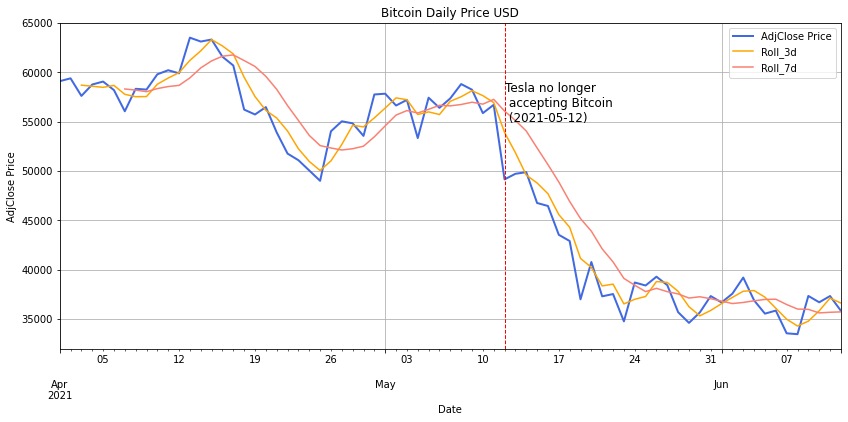

In [8]:
#@title Plot Close Price
fig, ax = plt.subplots(figsize=(14,6))
#ax.plot(df['AdjClose'], lw=2., label='AdjClose Price',c='royalblue')
df_2021[df_2021.index.month>=4]['AdjClose'].plot(lw=2., label='AdjClose Price',c='royalblue', ax=ax)
df_2021[df_2021.index.month>=4]['AdjClose'].rolling(3).mean().plot(lw=1.5, label='Roll_3d',c='orange', ax=ax)
df_2021[df_2021.index.month>=4]['AdjClose'].rolling(7).mean().plot(lw=1.5, label='Roll_7d', c='salmon', ax=ax)
ax.axvline(pd.to_datetime('2021-05-12'), color='r', linestyle='--', lw=1)
ax.text(pd.to_datetime('2021-05-12'), 55000, 
        "Tesla no longer \n accepting Bitcoin \n (2021-05-12) ", size=12)
#ax.axvline(pd.to_datetime('2015-11-01'), color='r', linestyle='--', lw=2)
plt.title('Bitcoin Daily Price USD')
plt.ylabel('AdjClose Price')
plt.grid(); plt.legend()

## Apply Causal Impact model - default model, local level only

In [9]:
pre_period = [df_2021.index.min(), '2021-05-12']
post_period = ['2021-05-13', df_2021.index.max()] #june 12th 

In [10]:
ci = CausalImpact(df_2021['AdjClose'], pre_period, post_period,)

/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/structural.py:1772: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  warn('Exogenous array provided to predict, but additional data not'


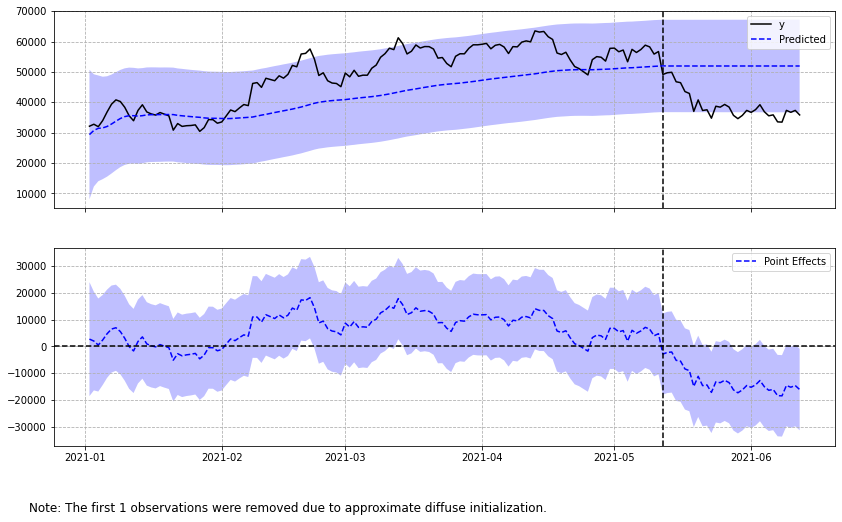

In [11]:
ci.plot(panels=['original', 'pointwise'], figsize=(14, 8))

In [12]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    38737.26           1200855.19
Prediction (s.d.)         51946.23 (1651.95) 1610333.1 (51210.38)
95% CI                    [48750.2, 55225.72][1511256.22, 1711997.21]

Absolute effect (s.d.)    -13208.96 (1651.95)-409477.91 (51210.38)
95% CI                    [-16488.45, -10012.94][-511142.02, -310401.03]

Relative effect (s.d.)    -25.43% (3.18%)    -25.43% (3.18%)
95% CI                    [-31.74%, -19.28%] [-31.74%, -19.28%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


## Add seasonality component

* Defaults to 0.01, a typical choice for well-behaved and stable datasets with low residual volatility after regressing out known predictors (e.g., web searches or sales in high quantities). 
* When in doubt, a safer option is to use 0.1, as validated on synthetic data, although this may sometimes give rise to unrealistically wide prediction intervals.
* in python implementation, specifying it as `None` - the package will by itself to optimize this parameter using maximum likelihood estimation.

In [13]:
ci_season = CausalImpact(df_2021['AdjClose'], 
                         pre_period, post_period, 
                         nseasons=[{'period': 7, 'harmonics':1}, 
                                   {'period': 30, 'harmonnics':1}], 
                         prior_level_sd=0.1) #0.01 is the default

/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/structural.py:1772: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  warn('Exogenous array provided to predict, but additional data not'


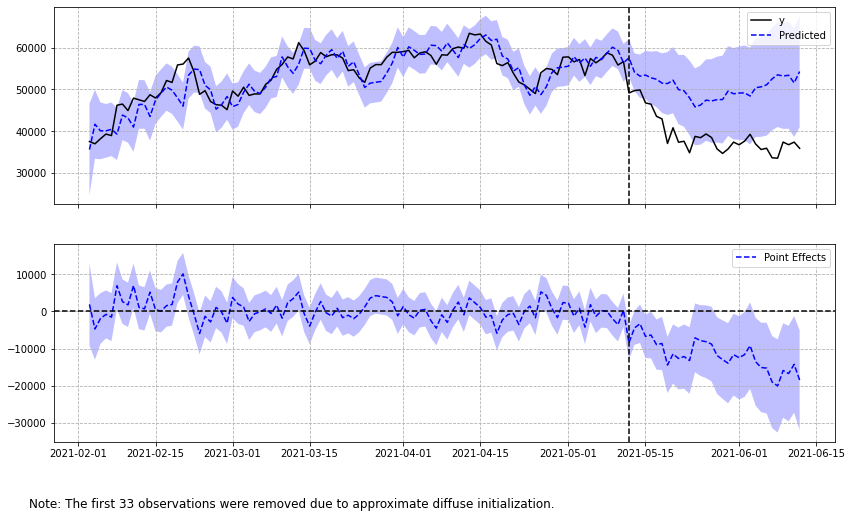

In [14]:
ci_season.plot(panels=['original', 'pointwise'], figsize=(14, 8))

In [15]:
ci_season.trained_model.params

sigma2.irregular               1.439853e-02
sigma2.level                   1.440000e-02
sigma2.freq_seasonal_7(1)      1.997536e-10
sigma2.freq_seasonal_30(15)    7.570167e-06
dtype: float64

In [16]:
print(ci_season.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    38737.26           1200855.19
Prediction (s.d.)         50534.38 (4054.86) 1566565.67 (125700.61)
95% CI                    [42390.72, 58285.47][1314112.35, 1806849.68]

Absolute effect (s.d.)    -11797.11 (4054.86)-365710.48 (125700.61)
95% CI                    [-19548.21, -3653.46][-605994.49, -113257.16]

Relative effect (s.d.)    -23.34% (8.02%)    -23.34% (8.02%)
95% CI                    [-38.68%, -7.23%]  [-38.68%, -7.23%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


In [17]:
print(ci_season.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 38737.26. By contrast, in the absence of an
intervention, we would have expected an average response of 50534.38.
The 95% interval of this counterfactual prediction is [42390.72, 58285.47].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -11797.11 with a 95% interval of
[-19548.21, -3653.46]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1200855.19.
By contrast, had the intervention not taken place, we would have expected
a sum of 1566565.67. The 95% interval of this prediction is [1314112.35, 1806849.68].


The above results are given in terms of absolute numbers.

/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/structural.py:1772: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  warn('Exogenous array provided to predict, but additional data not'


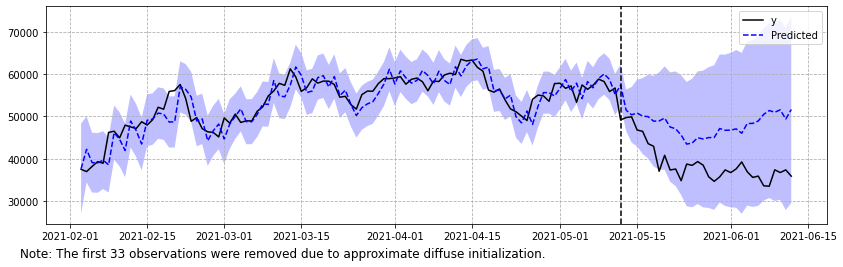

In [19]:
# Prior as None
ci_season = CausalImpact(df_2021['AdjClose'], 
                         pre_period, post_period, 
                         nseasons=[{'period': 7, 'harmonics':1}, 
                                   {'period': 30, 'harmonnics':1}], 
                         prior_level_sd=None) #0.01 is the default
ci_season.plot(panels=['original'], figsize=(14, 4))

In [20]:
print(ci_season.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    38737.26           1200855.19
Prediction (s.d.)         48101.5 (6329.16)  1491146.56 (196204.07)
95% CI                    [35637.19, 60447.06][1104752.95, 1873858.77]

Absolute effect (s.d.)    -9364.24 (6329.16) -290291.37 (196204.07)
95% CI                    [-21709.79, 3100.07][-673003.58, 96102.24]

Relative effect (s.d.)    -19.47% (13.16%)   -19.47% (13.16%)
95% CI                    [-45.13%, 6.44%]   [-45.13%, 6.44%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 91.91%

For more details run the command: print(impact.summary('report'))


## Use covariates - S&P500 as a regressor

In [21]:
SP500 = pd.read_csv("../data/S&P500.csv", header=0)
SP500['Date'] = pd.to_datetime(SP500['Date'])
SP500.set_index(SP500['Date'], inplace=True)
SP500.drop(columns={'Date'},inplace=True)
SP500.rename(columns={"AdjClose":"AdjClose_sp500"}, inplace=True)
SP500.head()

,Open,High,Low,Close*,AdjClose_sp500
Date,,,,,
2021-06-11,4242.90,4248.38,4232.25,4247.44,4247.44
2021-06-10,4228.56,4249.74,4220.34,4239.18,4239.18
2021-06-09,4232.99,4237.09,4218.74,4219.55,4219.55
2021-06-08,4233.81,4236.74,4208.41,4227.26,4227.26
2021-06-07,4229.34,4232.34,4215.66,4226.52,4226.52


Text(0.5, 1.0, 'S&P500 Daily Price USD, 2021')

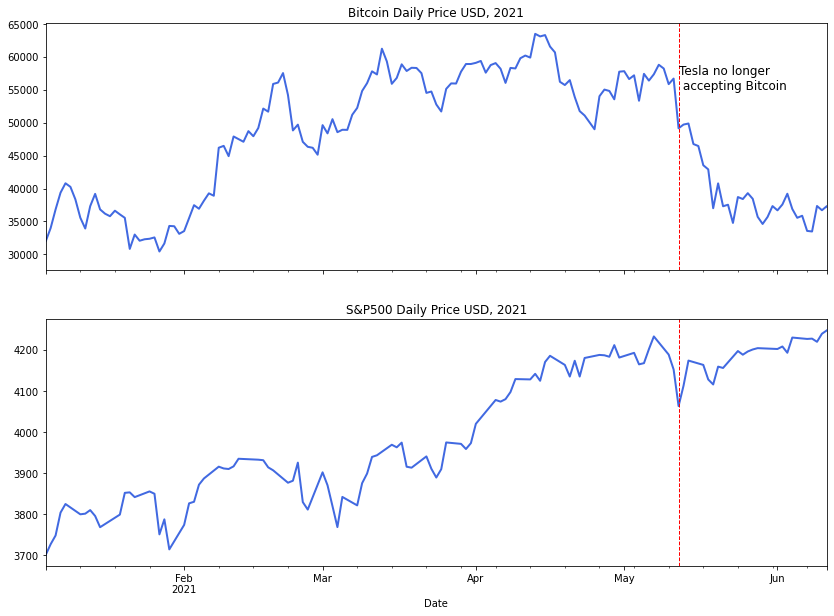

In [22]:
#@title Plot Close Price
fig, axes = plt.subplots(2,1, figsize=(14,10), sharex=True)
axes = axes.flatten()
#ax.plot(df['AdjClose'], lw=2., label='AdjClose Price',c='royalblue')
df_2021['AdjClose'].plot(lw=2., label='AdjClose Price',c='royalblue', ax=axes[0])
SP500[SP500.index.year>=2021].AdjClose_sp500.plot(lw=2., label='S&P500 Price',c='royalblue', ax=axes[1])
axes[0].axvline(pd.to_datetime('2021-05-12'), color='r', linestyle='--', lw=1)
axes[1].axvline(pd.to_datetime('2021-05-12'), color='r', linestyle='--', lw=1)
axes[0].text(pd.to_datetime('2021-05-12'), 55000, 
        "Tesla no longer \n accepting Bitcoin", size=12)
axes[0].set_title('Bitcoin Daily Price USD, 2021')
axes[1].set_title('S&P500 Daily Price USD, 2021')

In [23]:
df_cov = df.merge(SP500['AdjClose_sp500'], 
                  left_index=True, right_index=True)
df_cov=df_cov[['AdjClose', 'AdjClose_sp500']]
df_cov.head()

,AdjClose,AdjClose_sp500
Date,,
2020-06-12,9480.84,3041.31
2020-06-15,9450.70,3066.59
2020-06-16,9538.02,3124.74
2020-06-17,9480.25,3113.49
2020-06-18,9411.84,3115.34


In [24]:
df_cov.corr()

,AdjClose,AdjClose_sp500
AdjClose,1.000000,0.883995
AdjClose_sp500,0.883995,1.000000


In [25]:
df_cov = df_cov[df_cov.index.year>=2021].copy()

In [26]:
pre_period = [df_cov.index.min(), '2021-05-12']
post_period = ['2021-05-13', df_cov.index.max()]

In [27]:
ci_sp500 = CausalImpact(df_cov, 
                        pre_period, post_period, 
                        nseasons=[{'period': 7}, 
                                   {'period': 30}], 
                        prior_level_sd=0.1)

/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:217: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:573: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:217: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


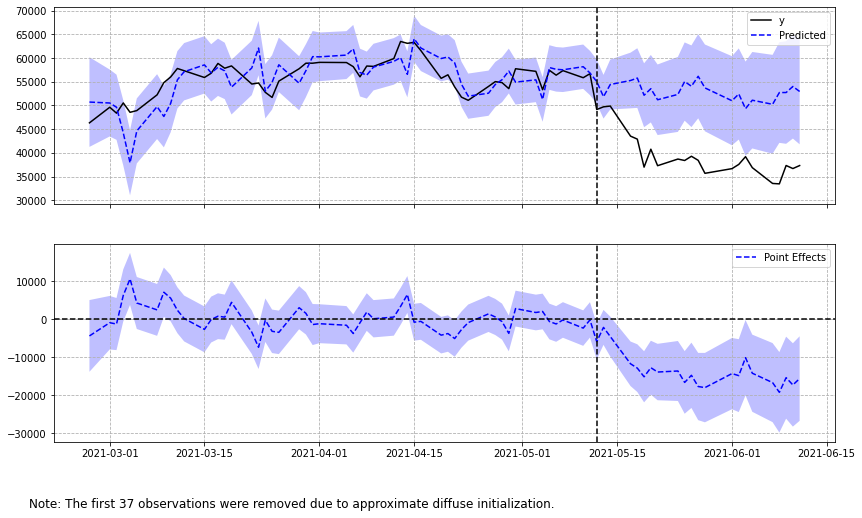

In [28]:
ci_sp500.plot(panels=['original', 'pointwise'], figsize=(14, 8))

In [29]:
ci_sp500.trained_model.params

sigma2.irregular               1.500970e-02
sigma2.level                   1.440000e-02
sigma2.freq_seasonal_7(3)      1.281501e-11
sigma2.freq_seasonal_30(15)    1.892630e-11
beta.AdjClose_sp500            4.228078e-01
dtype: float64

In [30]:
print(ci_sp500.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    39069.01           820449.24
Prediction (s.d.)         52958.26 (3454.05) 1112123.53 (72535.08)
95% CI                    [46362.78, 59902.41][973618.38, 1257950.68]

Absolute effect (s.d.)    -13889.25 (3454.05)-291674.29 (72535.08)
95% CI                    [-20833.4, -7293.77][-437501.44, -153169.14]

Relative effect (s.d.)    -26.23% (6.52%)    -26.23% (6.52%)
95% CI                    [-39.34%, -13.77%] [-39.34%, -13.77%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


## Try some customeized model

In [31]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [32]:
from causalimpact.misc import standardize
normed_pre_data, _ = standardize(df_cov.iloc[:90])

In [33]:
normed_pre_data.head()

,AdjClose,AdjClose_sp500
Date,,
2021-01-04,-1.833893,-1.739850
2021-01-05,-1.620012,-1.562005
2021-01-06,-1.320238,-1.417612
2021-01-07,-1.050660,-1.040005
2021-01-08,-0.899651,-0.898259


In [45]:
cust_model = UnobservedComponents(
    endog=normed_pre_data['AdjClose'].iloc[:90],
    level='lltrend',
    exog=normed_pre_data['AdjClose_sp500'].iloc[:90],
    freq_seasonal=[{'period':30}, {'period':7}]
)
ci_cust = CausalImpact(df_cov, 
                       pre_period, post_period, 
                       model=cust_model, prior_level_sd=0.1)

/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:217: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:573: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:217: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


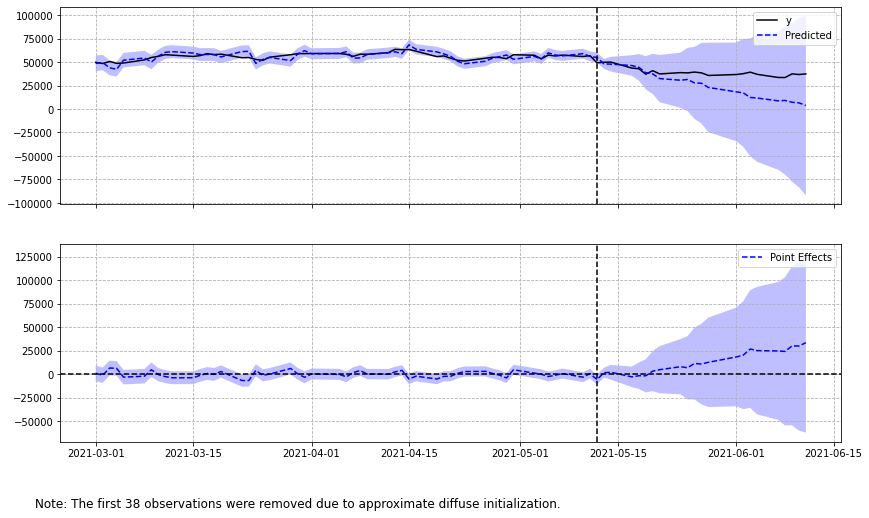

In [46]:
ci_cust.plot(panels=['original', 'pointwise'], figsize=(14, 8))

In [47]:
ci_cust.trained_model.params

sigma2.irregular               8.344126e-03
sigma2.level                   1.440000e-02
sigma2.trend                   5.600001e-03
sigma2.freq_seasonal_30(15)    7.302182e-11
sigma2.freq_seasonal_7(3)      1.555333e-11
beta.AdjClose_sp500            2.877265e-01
dtype: float64

In [48]:
print(ci_cust.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    39069.01           820449.24
Prediction (s.d.)         25210.5 (22418.56) 529420.53 (470789.74)
95% CI                    [-20105.09, 67774.04][-422206.96, 1423254.91]

Absolute effect (s.d.)    13858.51 (22418.56)291028.71 (470789.74)
95% CI                    [-28705.03, 59174.1][-602805.67, 1242656.2]

Relative effect (s.d.)    54.97% (88.93%)    54.97% (88.93%)
95% CI                    [-113.86%, 234.72%][-113.86%, 234.72%]

Posterior tail-area probability p: 0.26
Posterior prob. of a causal effect: 73.83%

For more details run the command: print(impact.summary('report'))


# VW

In [202]:
vw = pd.read_csv('../data/vw.csv', header=0)

In [203]:
vw['Date'] = pd.to_datetime(vw['Date'])
vw.set_index(vw['Date'], inplace=True)
vw.drop(columns={'Date'},inplace=True)

In [204]:
vw.head()

,VolksWagen,BMW,Allianz
Date,,,
2011-01-02,99.142822,45.039032,60.006882
2011-01-09,100.908623,44.758060,63.032661
2011-01-16,96.084999,42.297653,64.578583
2011-01-23,96.558739,43.360786,66.296272
2011-01-30,94.965218,43.170944,69.962891


/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/munji.choi/Documents/misc/causal_impact/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    126.91             10026.07
Prediction (s.d.)         175.24 (2.92)      13844.0 (230.82)
95% CI                    [169.48, 180.94]   [13389.23, 14294.01]

Absolute effect (s.d.)    -48.33 (2.92)      -3817.93 (230.82)
95% CI                    [-54.02, -42.57]   [-4267.95, -3363.16]

Relative effect (s.d.)    -27.58% (1.67%)    -27.58% (1.67%)
95% CI                    [-30.83%, -24.29%] [-30.83%, -24.29%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


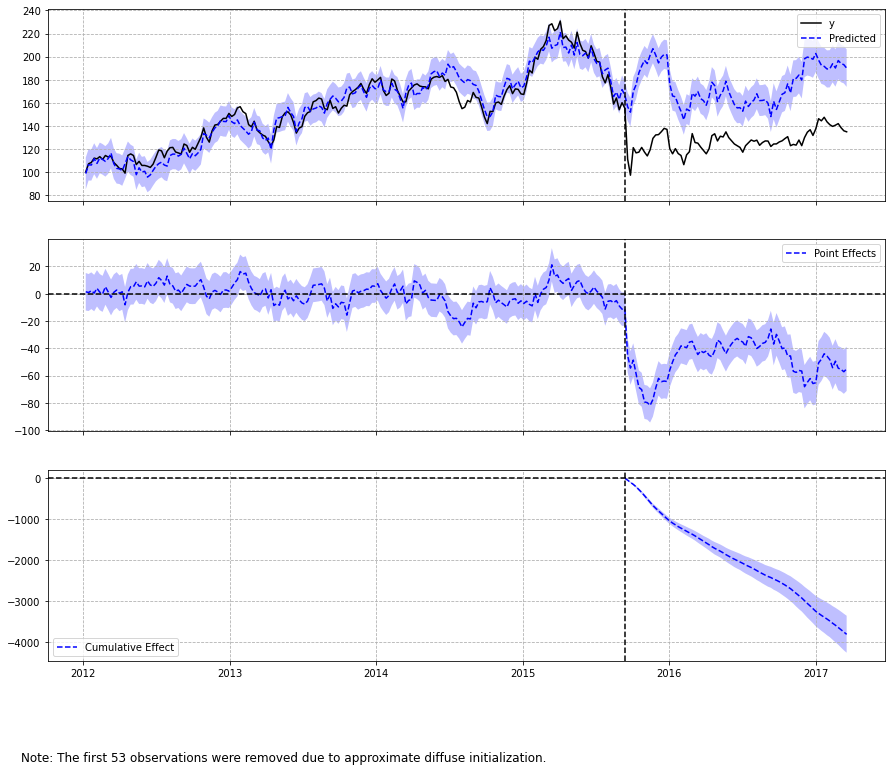

In [208]:
pre_period = [vw.index.min(), "2015-09-13"]
post_period = ["2015-09-20", vw.index.max()]

ci = CausalImpact(vw, pre_period, post_period, nseasons=[{'period': 52}])
print(ci.summary())
ci.plot()

In [209]:
ci.trained_model.params

sigma2.irregular               0.009708
sigma2.level                   0.000144
sigma2.freq_seasonal_52(26)    0.000008
beta.BMW                       0.728108
beta.Allianz                   0.266366
dtype: float64